In [7]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import uproot

In [8]:
rng = np.random.Generator(np.random.PCG64(42))

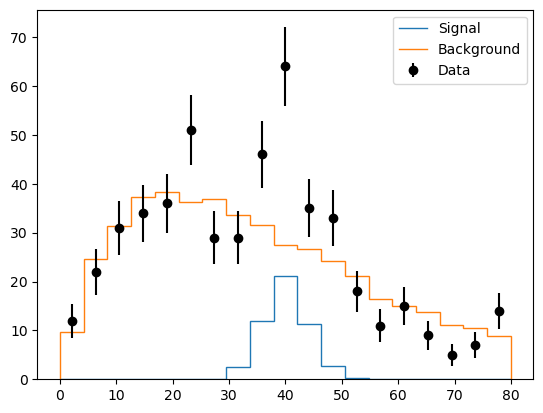

In [10]:
sig_mass = rng.normal(loc=40.0, scale=4.0, size=1_000)
sig_w = np.ones_like(sig_mass) * 0.05

bkg_mass = rng.exponential(scale=20.0, size=10_000) + rng.exponential(scale=20.0, size=10_000)
bkg_w = np.ones_like(bkg_mass) * 0.05

edges = np.linspace(0, 80, 20)
centers = 0.5*(edges[1:] + edges[:-1])
sig_hist = np.histogram(sig_mass, bins=edges, weights=sig_w)
bkg_hist = np.histogram(bkg_mass, bins=edges, weights=bkg_w)

data_obs = rng.poisson(1.0 * sig_hist[0] + bkg_hist[0])

fig, ax = plt.subplots()
ax.stairs(*sig_hist, label="Signal")
ax.stairs(*bkg_hist, label="Background")
ax.errorbar(
    x=centers, y=data_obs, yerr=np.sqrt(data_obs),
    linestyle="none", marker="o", color="k", label="Data"
)
ax.legend()

In [15]:
bkg_hist[0]

array([ 9.7 , 24.6 , 31.4 , 37.35, 38.35, 36.35, 36.9 , 33.6 , 31.65,
       27.4 , 26.6 , 24.25, 21.1 , 16.4 , 15.  , 13.8 , 11.15, 10.55,
        8.85])

In [25]:
from scipy.special import xlogy

def poisson_logprob(n, λ):
    """log(λ^n e^-λ)"""
    return xlogy(n, λ) - λ


@np.vectorize
def nll(mu):
    return_val_vec  = -poisson_logprob(data_obs, mu*sig_hist[0] + bkg_hist[0])
    # print(f"return_val_vec.shape: {return_val_vec.shape}")
    return return_val_vec.sum()


def nll_inherently_vectorized(mu):
    return -poisson_logprob(data_obs, mu[:, None]*sig_hist[0] + bkg_hist[0]).sum(axis=1)


mus = np.linspace(0, 3, 10000)
# print(nll(mus).shape)
# print(nll_inherently_vectorized(mus).shape)
%timeit nll(mus)
%timeit nll_inherently_vectorized(mus)

67.5 ms ± 441 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.73 ms ± 11.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
from scipy.optimize import minimize

fit = minimize(nll_inherently_vectorized, 0.0)
# fit = minimize(nll, 0.0)

fit

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1214.4582625627095
        x: [ 1.395e+00]
      nit: 6
      jac: [ 0.000e+00]
 hess_inv: [[ 6.854e-02]]
     nfev: 14
     njev: 7

In [38]:
np.min(nll)

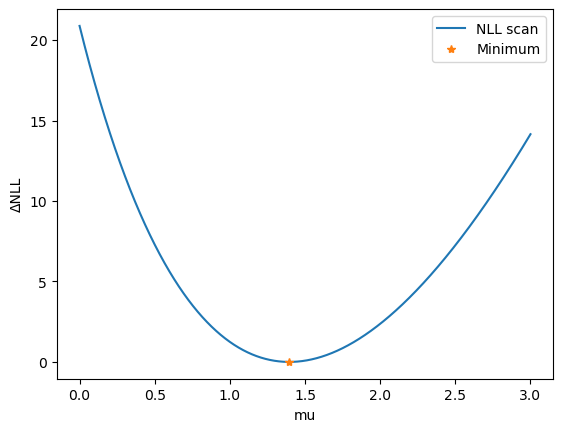

In [39]:
from scipy.optimize import minimize

fit = minimize(nll, 0.0)

fig, ax = plt.subplots()

ax.plot(mus, nll(mus) - fit.fun, label="NLL scan")
ax.plot(fit.x, 0.0, marker="*", linestyle="none", label="Minimum")
ax.set_xlabel("mu")
ax.set_ylabel("ΔNLL")
ax.legend()

In [40]:
with uproot.recreate("shapes.root") as fout:
    fout["sig"] = sig_hist
    fout["bkg"] = bkg_hist
    fout["data_obs"] = (data_obs, edges)

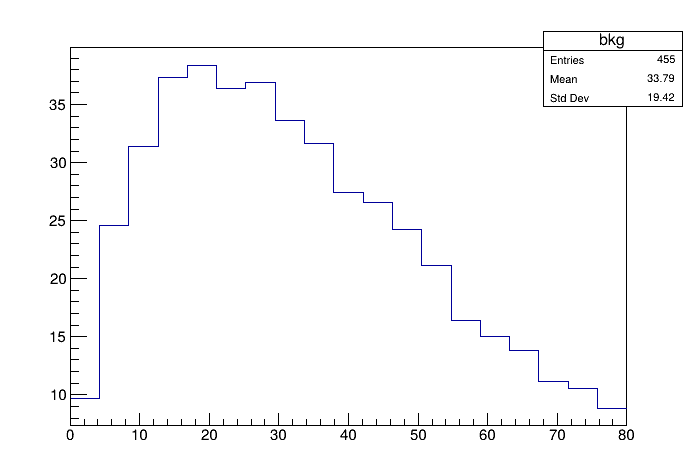

In [41]:
import ROOT

fin = ROOT.TFile.Open("shapes.root")
c1 = ROOT.TCanvas()
fin.Get("bkg").Draw()
c1.Draw()

In [42]:
data_obs.sum(), sig_hist[0].sum(), bkg_hist[0].sum()

(501, 49.9999999999993, 455.0000000000692)

In [82]:
# import os

# os.environ["PATH"] += ":/tmp/HiggsAnalysis/CombinedLimit/build/bin"
# os.environ["LD_LIBRARY_PATH"] += ":/tmp/HiggsAnalysis/CombinedLimit/build/lib"
# os.environ["PYTHONPATH"] = "/tmp/HiggsAnalysis/CombinedLimit/build/lib/python"

In [ ]:
%%writefile card.txt
imax 1 number of channels
jmax 1 number of backgrounds
kmax 1 number of systematics
shapes * * shapes.root $PROCESS
---
bin bin1
observation 501
---
bin       bin1    bin1
process      0       1
process    sig     bkg
rate        50   455.0
---
lumi lnN  1.03    1.03

In [45]:
%%writefile card.txt
imax 1 number of channels
jmax 1 number of backgrounds
kmax 1 number of systematics
shapes sig * shapes.root sig
shapes bkg * shapes.root bkg
shapes data_obs * shapes.root data_obs

---
bin bin1
observation 501
---
bin       bin1    bin1
process      0       1
process    sig     bkg
rate        50   455.0
---
lumi lnN  1.03    1.03

Overwriting card.txt


In [46]:
%%bash

combine -M MultiDimFit card.txt --algo grid --setParameterRanges r=0,3 --trackParameters lumi

 <<< Combine >>> 
 <<< v10.0.1 >>>
>>> Random number generator seed is 123456
>>> Method used is MultiDimFit
Set Range of Parameter r To : (0,3)
Doing initial fit: 
 POI: r= 1.44847 -> [0,3]
Point 0/50 r = 0.03
Point 1/50 r = 0.09
Point 2/50 r = 0.15
Point 3/50 r = 0.21
Point 4/50 r = 0.27
Point 5/50 r = 0.33
Point 6/50 r = 0.39
Point 7/50 r = 0.45
Point 8/50 r = 0.51
Point 9/50 r = 0.57
Point 10/50 r = 0.63
Point 11/50 r = 0.69
Point 12/50 r = 0.75
Point 13/50 r = 0.81
Point 14/50 r = 0.87
Point 15/50 r = 0.93
Point 16/50 r = 0.99
Point 17/50 r = 1.05
Point 18/50 r = 1.11
Point 19/50 r = 1.17
Point 20/50 r = 1.23
Point 21/50 r = 1.29
Point 22/50 r = 1.35
Point 23/50 r = 1.41
Point 24/50 r = 1.47
Point 25/50 r = 1.53
Point 26/50 r = 1.59
Point 27/50 r = 1.65
Point 28/50 r = 1.71
Point 29/50 r = 1.77
Point 30/50 r = 1.83
Point 31/50 r = 1.89
Point 32/50 r = 1.95
Point 33/50 r = 2.01
Point 34/50 r = 2.07
Point 35/50 r = 2.13
Point 36/50 r = 2.19
Point 37/50 r = 2.25
Point 38/50 r = 2.31


In [48]:
with uproot.open("higgsCombineTest.MultiDimFit.mH120.root") as fin:
    data = fin["limit"].arrays()

bestfit = data[0]
scan = data[1:]

In [61]:
bestfit.r

1.4484733

In [65]:
def full_nll(mu, lumi_np):
    expectation = mu*sig_hist[0] + bkg_hist[0]
    # print(f"lumi_np: {lumi_np}")
    expectation *= 1.03**lumi_np
    poisson_term = -poisson_logprob(data_obs, expectation).sum()
    aux_term = 0.5 * lumi_np**2
    return poisson_term + aux_term

@np.vectorize
def profile_nll(mu):
    fit = minimize(lambda lumi_np: full_nll(mu, lumi_np), 0.0) # I think you're minimizing the lumi nuisance parameter
    # print(fit)
    # print(fit.fun)
    return fit.fun

(50,)
()


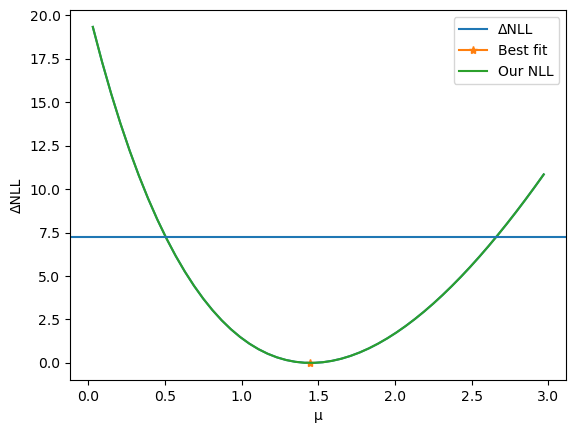

In [68]:
fig, ax = plt.subplots()

print((profile_nll(scan.r)).shape)
print((profile_nll(bestfit.r)).shape)
our_nll = profile_nll(scan.r) - profile_nll(bestfit.r)

ax.plot(scan.r, scan.deltaNLL, label="ΔNLL")
ax.plot(bestfit.r, 0.0, marker="*", label="Best fit")
ax.plot(scan.r, our_nll, label="Our NLL")
ax.axhline(0.5* 3.8**2)
ax.set_xlabel("μ")
ax.set_ylabel("ΔNLL")
ax.legend()

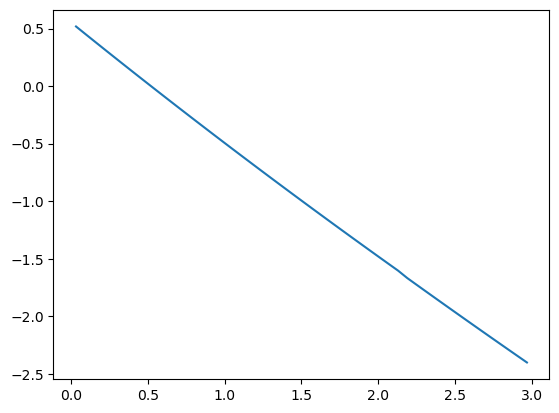

In [130]:
plt.plot(scan.r, scan.trackedParam_lumi)

In [69]:
q0 = 2*(profile_nll(0) - profile_nll(bestfit.r))

np.sqrt(q0)

6.388315287471726

In [70]:
%%bash

combine -M Significance card.txt

 <<< Combine >>> 
 <<< v10.0.1 >>>
>>> Random number generator seed is 123456
>>> Method used is Significance

 -- Significance -- 
Significance: 6.38832
Done in 0.00 min (cpu), 0.00 min (real)


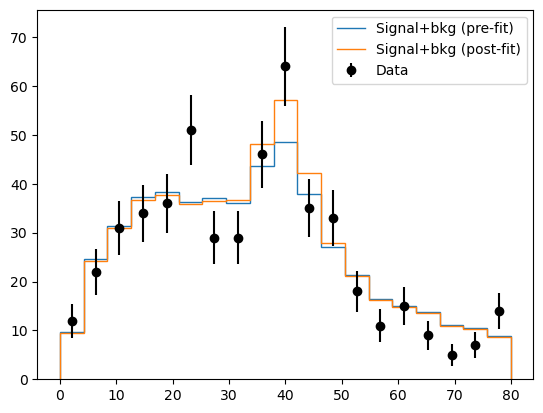

In [71]:
fig, ax = plt.subplots()

expectation = (bestfit.r * sig_hist[0] + bkg_hist[0]) * 1.03**bestfit.trackedParam_lumi

ax.stairs(sig_hist[0] + bkg_hist[0], edges=edges, label="Signal+bkg (pre-fit)")
ax.stairs(expectation, edges=edges, label="Signal+bkg (post-fit)")
ax.errorbar(
    x=centers, y=data_obs, yerr=np.sqrt(data_obs),
    linestyle="none", marker="o", color="k", label="Data"
)
ax.legend()